# Цена предзаказа

Заказчик исследования — сеть отелей «Как в гостях».

Чтобы привлечь клиентов, сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.

## Цель

Оценить влияние на бизнес-показатели опции бронирования номера без предоплаты.  

## Задачи

1. Оцените прибыль отеля без внедрения депозитов.
1. Разработать систему предсказания отказа от брони
1. Выявить признаки «ненадёжного» клиента

## Дополнительные условия

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

Стоимость номеров отеля:
- категория A: за ночь — 1 000, разовое обслуживание — 400;
- категория B: за ночь — 800, разовое обслуживание — 350;
- категория C: за ночь — 600, разовое обслуживание — 350;
- категория D: за ночь — 550, разовое обслуживание — 150;
- категория E: за ночь — 500, разовое обслуживание — 150;
- категория F: за ночь — 450, разовое обслуживание — 150;
- категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.

На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за год. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

## Описание данных

В таблицах hotel_train и hotel_test содержатся одинаковые столбцы:
- id — номер записи;
- adults — количество взрослых постояльцев;
- arrival_date_year — год заезда;
- arrival_date_month — месяц заезда;
- arrival_date_week_number — неделя заезда;
- arrival_date_day_of_month — день заезда;
- babies — количество младенцев;
- booking_changes — количество изменений параметров заказа;
- children — количество детей от 3 до 14 лет;
- country — гражданство постояльца;
- customer_type — тип заказчика:
    * Contract — договор с юридическим лицом;
    * Group — групповой заезд;
    * Transient — не связано с договором или групповым заездом;
    * Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
- days_in_waiting_list — сколько дней заказ ожидал подтверждения;
- distribution_channel — канал дистрибуции заказа;
- is_canceled — отмена заказа;
- is_repeated_guest — признак того, что гость бронирует номер второй раз;
- lead_time — количество дней между датой бронирования и датой прибытия;
- meal — опции заказа:
    - SC — нет дополнительных опций;
    - BB — включён завтрак;
    - HB — включён завтрак и обед;
    - FB — включён завтрак, обед и ужин.
- previous_bookings_not_canceled — количество подтверждённых заказов у клиента;
- previous_cancellations — количество отменённых заказов у клиента;
- required_car_parking_spaces — необходимость места для автомобиля;
- reserved_room_type — тип забронированной комнаты;
- stays_in_weekend_nights — количество ночей в выходные дни;
- stays_in_week_nights — количество ночей в будние дни;
- total_nights — общее количество ночей;
- total_of_special_requests — количество специальных отметок.

## Загрузка библиотек и данных

In [1]:
import sys
from distutils.version import StrictVersion

if StrictVersion(sys.version.split()[0]) < StrictVersion('3.8.0'):
    !pip install -U seaborn

In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

In [3]:
try:
    from imblearn.over_sampling import ADASYN
    from imblearn.under_sampling import ClusterCentroids
except:
    !pip install imblearn
    from imblearn.over_sampling import ADASYN
    from imblearn.under_sampling import ClusterCentroids

In [4]:
pd.set_option("display.precision", 2)
pd.set_option("display.max_columns", 100)
pd.options.mode.chained_assignment = None

sns.set(rc={"figure.figsize": (12, 8)})

warnings.filterwarnings("ignore")

In [5]:
try:
    hotel_train = pd.read_csv("./hotel_train.csv")
    hotel_test = pd.read_csv("./hotel_test.csv")
except FileNotFoundError:
    hotel_train = pd.read_csv("/datasets/hotel_train.csv")
    hotel_test = pd.read_csv("/datasets/hotel_test.csv")

In [6]:
hotel_train.head()

In [7]:
hotel_train.info()

In [8]:
hotel_test.info()

In [9]:
hotel_train.describe()

In [10]:
(
    hotel_train.drop("id", axis=1).duplicated().sum(),
    hotel_test.drop("id", axis=1).duplicated().sum(),
)

Обнаружились дубликаты, причём и в тренировочной и в тестовой выборках. Избавимся от них.

In [11]:
cols = list(hotel_train.columns)
cols.remove("id")
hotel_train.drop_duplicates(subset=cols, inplace=True)
hotel_test.drop_duplicates(subset=cols, inplace=True)

Теперь в данных отсутствуют пропуски и дубликаты, но типы данных не во всех колонках соответсвуют содержанию. 

## Предобработка данных 

Для того, чтобы единообразно преобразовать типы и тренировочной и тестовой выборок напишем функецию преобразования и применим её к обоим датафреймам

In [12]:
def types_repair(df):
    # значения по смыслу целые
    df[["adults", "children", "babies", "lead_time"]] = df[
        ["adults", "children", "babies", "lead_time"]
    ].astype("int")
    # в полях meal и reserved_room_type присутсвуют значения с лишними пробелами
    df["meal"] = df["meal"].str.strip()
    df["reserved_room_type"] = df["reserved_room_type"].str.strip()
    # категориальные значения
    # в том числе и связанные с датами: это устраняет ненужную упорядоченность значений (52я неделя не больше 2й)
    df[
        [
            "meal",
            "country",
            "arrival_date_month",
            "arrival_date_week_number",
            "arrival_date_day_of_month",
            "distribution_channel",
            "reserved_room_type",
            "customer_type",
        ]
    ] = df[
        [
            "meal",
            "country",
            "arrival_date_month",
            "arrival_date_week_number",
            "arrival_date_day_of_month",
            "distribution_channel",
            "reserved_room_type",
            "customer_type",
        ]
    ].astype(
        "category"
    )
    return df

In [13]:
hotel_train = types_repair(hotel_train)
hotel_test = types_repair(hotel_test)

Теперь взглянем на соотношение целевых классов:

In [14]:
(
    hotel_train[hotel_train["is_canceled"] == 0].shape[0],
    hotel_train[hotel_train["is_canceled"] == 1].shape[0],
)

Дисбаланс классов присутствует, но он не слишком велик: из забронировавших номер, отказывается в среднем каждый третий. Значит можно обойтись без балансировки.

### Анализ признаков ненадёжных постояльцев

Перед тем, как переходить к обучению моделей, попробуем увидеть особенности в исходных данных.

In [ ]:
%%time
sns.pairplot(hotel_train.drop(["id"], axis=1), hue="is_canceled");

В глаза бросаются ряд различий.

Ненадёжные клиенты значительно реже отдыхают с младенцами, что логично: родители с маленькими детьми, в среднем достаточно ответствены.

In [15]:
(
    hotel_train[hotel_train["is_canceled"] == 0]["babies"].mean(),
    hotel_train[hotel_train["is_canceled"] == 1]["babies"].mean(),
)

Большинство и надёжных и ненадёжных постояльцев отдыхают без младенцев, но среди тех, кто живёт в отеле с младенцами, доль надёжных существенна, даже с учётом их большей численности.

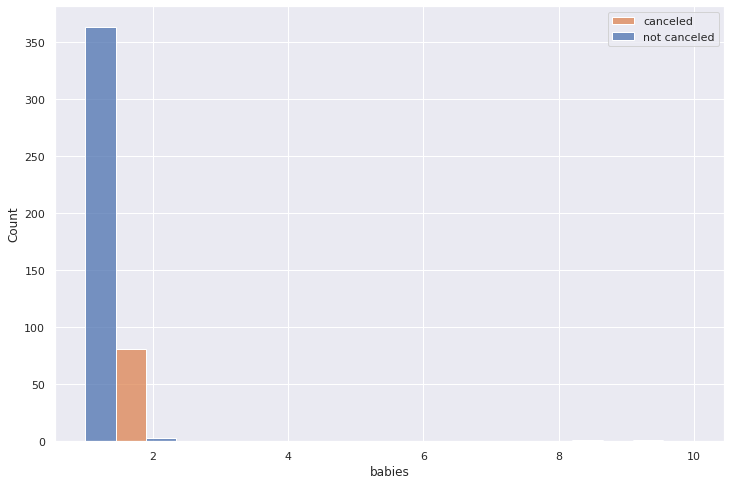

In [16]:
ax = sns.histplot(
    data=hotel_train[hotel_train["babies"] > 0],
    x="babies",
    hue="is_canceled",
    multiple="dodge",
)
ax.legend(["canceled", "not canceled"]);

Странно, что количество младенцев может достигать 10. Это какие-то передвижные ясли.

Также ненадёжные поcтояльцы не бронируют парковочные места.

In [17]:
(
    hotel_train[hotel_train["is_canceled"] == 0]["required_car_parking_spaces"].mean(),
    hotel_train[hotel_train["is_canceled"] == 1]["required_car_parking_spaces"].mean(),
)

Кроме того, выделяется заметная разница в странах, откуда прибывают туристы.

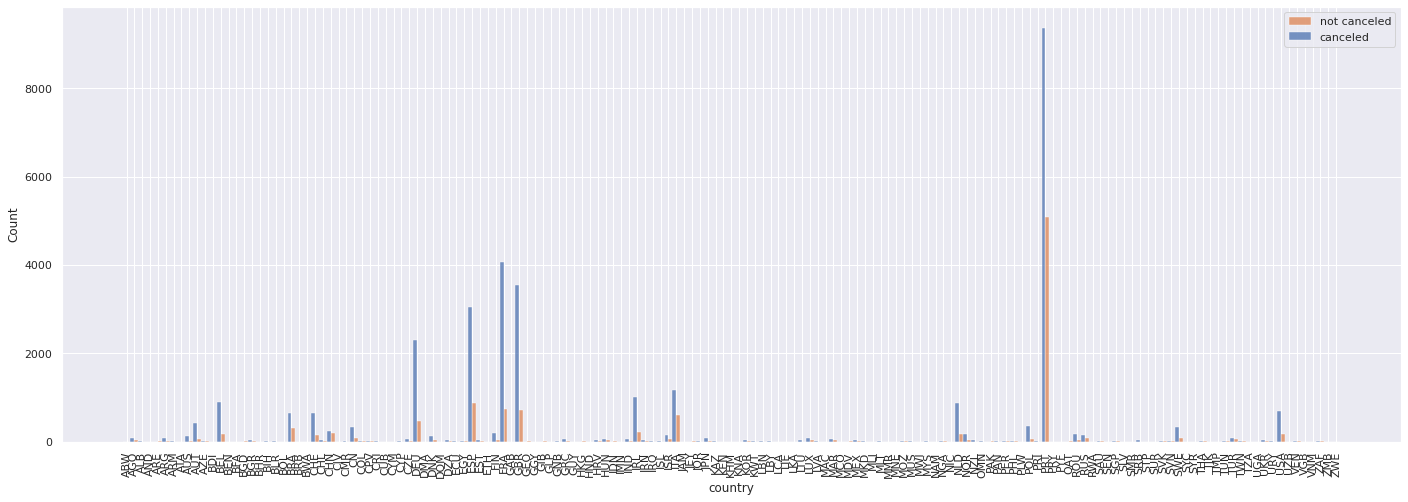

In [18]:
fig, ax = plt.subplots(figsize=(24, 8))
sns.histplot(
    data=hotel_train,
    x="country",
    hue="is_canceled",
    multiple="dodge",
)

# ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.xticks(rotation=90)
ax.legend(["not canceled", "canceled"]);

Видно, что существуют страны, путешественники из которых чаще отменяют бронь, чем пользуются ею. 

In [19]:
cnts = hotel_train["country"].value_counts()

hotel_train[hotel_train["country"].isin(cnts[cnts > 5].index)].groupby("country").agg(
    {"is_canceled": lambda x: sum(x) / len(x)}
).sort_values(by="is_canceled", ascending=False).dropna().head(20)

Наша функция возвращает отношение числа отказов к общему числу бронирований, так что значение [0, 0.5] говорит, о том, что число отказов не превышает число заездов  из данной страны. 

Интересно, что путешествующие двоём и имевшые до того отмены брони, склонны часто повторно отказываться от забронированных номеров.

Интересно, что если путешественник делает специальные отметки, то шансы отмены брони существенно снижаются.

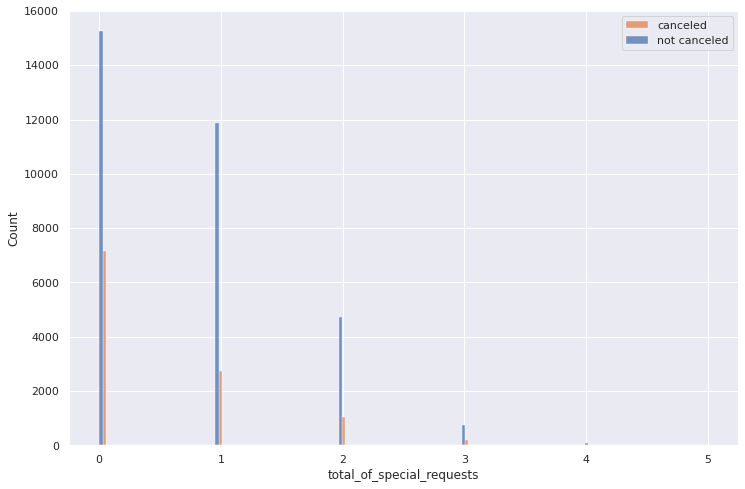

In [20]:
ax = sns.histplot(
    data=hotel_train,
    x="total_of_special_requests",
    hue="is_canceled",
    multiple="dodge",
)
ax.legend(["canceled", "not canceled"]);

In [21]:
hotel_train[hotel_train["days_in_waiting_list"] == 224]

In [22]:
hotel_train[hotel_train["adults"] == 0].shape[0]

И даже

In [23]:
hotel_train[
    (hotel_train["adults"] == 0)
    & (hotel_train["children"] == 0)
    & (hotel_train["babies"] == 0)
].shape[0]

Можно предположить, что это ошибка: дети до 14 лет не могут путешествовать самостоятельно. От записей с нулевым количеством взрослых постояльцев следует избавиться. От записей с 9 и 10 младенцами - тоже.

In [24]:
hotel_train.drop(hotel_train[hotel_train["babies"] >= 9].index, axis=0, inplace=True)
hotel_train.drop(hotel_train[hotel_train["adults"] == 0].index, axis=0, inplace=True)

### Выводы

Данные подготовлены: проведено преобразование типов к более соответсвующим значениям параметров. 

Кроме того, был проведён исследовательский анализ исходных данных, который позволил выявить некоторые закономерности, связвающие вероятность отказа от брони к такими параметрами, как наличие в семье младенцев, бронирование парковочных мест, страна, из которой прибыл путешественник, а также наличие у туриста особых пожеланий.

## Вычисление бизнес-метрик

Основная метрика - это прибыль. Она равна разнице между стоимостью проживания в номере и затратами на обслуживание перед заездом постояльца и во время его проживания (уборка производится раз в два дня). Стоимость проживания и обслуживаниязависит от класса номера. Кроме того на стоимость номера влияет сезонный фактор: весной +20%, летом +40%.

Бюджет разработки системы прогнозирования составляет 400 тысяч. Проект будет успешным, если прибыль от внедрения системы в течении года превысит затраты на разработку.

Для удобства заведём соответствующие константы.

In [25]:
development_budget = 4e5

In [26]:
classes = ["A", "B", "C", "D", "E", "F", "G"]
price = [1000, 800, 600, 550, 500, 450, 350]
service = [400, 350, 350, 150, 150, 150, 150]
taxes = pd.DataFrame(
    data={"reserved_room_type": classes, "price": price, "service": service},
)

In [27]:
taxes

Поскольку цена номера зависит от сезона, полезно добавить в датафреймы соответсвующий множитель

In [28]:
seasons = pd.DataFrame(
    {
        "arrival_date_month": [
            "March",
            "April",
            "May",
            "June",
            "July",
            "August",
            "September",
            "October",
            "November",
            "December",
            "January",
            "February",
        ],
        "season_factor": [1.2, 1.2, 1.2, 1.4, 1.4, 1.4, 1, 1, 1, 1, 1, 1],
    }
)

In [29]:
hotel_train.merge(seasons, on="arrival_date_month", how="left").head()

Напишем функцию, вычисляющую размер депозита при бронировании номера в зависимости от класса номера и сезона:

In [30]:
def add_deposit(df):
    df = df.merge(seasons, on="arrival_date_month", how="left").merge(
        taxes, on="reserved_room_type", how="left"
    )
    df["deposit"] = 0
    df.loc[df["predict_canceled"] == 1, "deposit"] = (
        (df["price"] + df["service"]) * df["season_factor"] * 0.8
    )
    return df

Также нам пригодится функция вычисляющая дополнительный доход от внедрения предсказательной системы, который принесут депозиты, удержанные у постояльцев, отменивших бронь

In [31]:
def model_income(df):
    # берём постояльцев отменивших бронь, которых предсказала наша модель
    df = df[(df["is_canceled"] == 1) & (df["predict_canceled"] == 1)]
    # вычисляем прибыль как сумма удержанных депозитов
    return df["deposit"].sum()

Наконец, напишем функцию вычисляющую доход:

In [32]:
def income(df):
    """
    функция принимает датафрейм и вычисляет доход отеля вычитая из прибыли расходы
    """
    df = df.merge(taxes, on="reserved_room_type", how="left").merge(
        seasons, on="arrival_date_month", how="left"
    )
    # расходы на уборку перед заездом постояльца (без учёта отмены брони)
    costs = (df["service"] * df["season_factor"]).sum()
    df = df[df["is_canceled"] == 0]
    # уборки при длительном проживании раз в 2 дня
    costs += (df["total_nights"] // 2 * df["service"] * df["season_factor"]).sum()
    profit = (df["total_nights"] * df["price"] * df["season_factor"]).sum()
    print(f"costs: {costs}")
    print(f"profit: {profit}")
    return profit - costs

In [33]:
income_train_base = income(hotel_train)
print(f"income: {income_train_base}")

In [34]:
income_test_base = income(hotel_test)
print(f"income: {income_test_base}")

На тренировочной выборке без системы прогнозирования доход сети отелей составила 68 млн за полтора года. На тестовой выборке доход составил 42 млн за 8 месяцев. Похоже, дела у сети отелей идут в гору: прогнозируемая доходность в 2017 почти на 30% больше, чем в 20105-2016.

### Выводы

Мы подготовились к вычислению бизнес-метрик и создали необходимые константы, а также написали ряд вспомогательных функций для вычисления прибыли и разметки сезонов.

## Разработка предсказательной модели

Прежде чем обучать модели подготовим датафреймы признаков и целевых параметров

In [35]:
X_train = hotel_train.drop(["is_canceled", "id"], axis=1)
y_train = hotel_train["is_canceled"]
X_test = hotel_test.drop(["is_canceled", "id"], axis=1)
y_test = hotel_test["is_canceled"]

Классификаторы, которые мы собираемся использовать в дальнейшем требуют числовых значений признаков, поэтому категориальные значения нужно превратить в наборы числовых колонок. Это лучше всего сделать временно объединив тренировочную и тестовую выборки

In [36]:
X = X_train.append(X_test)
X_w = pd.get_dummies(X, drop_first=True)
X_train_w = X_w.iloc[: X_train.shape[0]]
X_test_w = X_w.iloc[X_train.shape[0] :]

In [37]:
X_train.shape, X_train_w.shape, X_test.shape, X_test_w.shape

In [38]:
X_train_w.describe()

Классификаторы на деревьях не очень хорошо работаю на данных с one-hot-кодированием, т.к. при это порождается большое количество признаков, что замедляет работу и снижает точность результатов. Для обучения этих моделей используем порядковое кодирование с помощью функции LabelEncoder библиотеки sklearn

In [39]:
enc = LabelEncoder()
caterories = [
    "meal",
    "country",
    "arrival_date_year",
    "arrival_date_month",
    "arrival_date_week_number",
    "arrival_date_day_of_month",
    "distribution_channel",
    "reserved_room_type",
    "customer_type",
]
for c in caterories:
    X[c] = enc.fit_transform(X[c])

X_train_lbl = X.iloc[: X_train.shape[0]]
X_test_lbl = X.iloc[X_train.shape[0] :]

In [40]:
X_train_lbl.head()

Не смотря на то, что дисбаланс классов в исходных данных не очень велик, проверим, как балансировка скажется на моделях решающего дерева и случайного леса. Способов достич цели существует много. В простейшем случае можно просто случайным образом дублировать записи из класса 1. Но существует библиотека `imblearn`, в которой реализованы разные методы oversampling. Одним из наиболее эффективных является `ADASYN` (Adaptive Synthetic), который на основе информации о ближайших соседях элементов малого класса достраивает новые элементы "подобные" имеющимся (Haibo He, Yang Bai, Edwardo A Garcia, and Shutao Li. Adasyn: adaptive synthetic sampling approach for imbalanced learning).

In [41]:
X_over, y_over = ADASYN().fit_resample(X_train_lbl, y_train)

In [42]:
y_over.value_counts(normalize=True)

Далее нам нужно определиться с метриками: какие характеристики модели мы хотим улучшать. 
- В случае `accuracy` мы максимизируем количество точных прогнозов (как положительных, так и отрицательных). Вряд ли она является оптимальной в нашем случае.
- При использовании `precision` мы минимизируем ложно-положительные срабатывания, т.е. уменьшаем шанс на то, что потребуем депозита с надёжного постояльца. Это хорошо для имиджа отеля. Если модель будет считать всех туристов ненадёжными, `precision` будет равна доли реально ненадёжных постояльцев.
- Метрика `recall` минимизирует ложно-отрицательные срабатывания, т.е. старается любой ценой неупустить ненадёжного жильца. Это полоезно для бизнес-показателей. При нгаивной модели, недоверяющей никому, `recall` равен 1.
- Метрика `F1` гармонизирует два предыдущих метрики.
- Метрика `AUC-ROC` тем больше, чем меньше ошибок делает модель. 

Поскольку наша основная задача - предсказать как можно больше отмен брони и по возможности не беспокоить надёжных постояльцев, наиболее подхоящей мерой видится `AUC-ROC`

### Логистическая регрессия

Первая простая и быстрая модель - логистическая регрессия:

In [43]:
%%time
lr = LogisticRegression(random_state=42, n_jobs=-1, max_iter=100).fit(
    X_train_w, y_train
)

In [44]:
%%time
print(
    f"Precision: {cross_val_score(lr, X_train_w, y_train, scoring='precision').mean()}"
)
print(f"Recall: {cross_val_score(lr, X_train_w, y_train, scoring='recall').mean()}")
print(f"F1: {cross_val_score(lr, X_train_w, y_train, scoring='f1').mean()}")
roc_auc = cross_val_score(lr, X_train_w, y_train, scoring="roc_auc").mean()
print(f"AUC-ROC: {roc_auc}")

Получается, что наша модель угадывает достаточно посредственно: значение AUC-ROC 0,59. Попробуем её оптимизировать.

In [45]:
%%time
lr_cv = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=100),
    param_grid={
        "C": [0.001, 0.1, 1, 10, 20],
    },
    cv=5,
    scoring="roc_auc",
)
lr_cv.fit(X_train_w, y_train)

In [46]:
lr_cv.best_estimator_

Оценим качество полученной модели:

In [47]:
%%time
print(
    f"Precision: {cross_val_score(lr_cv.best_estimator_, X_train_w, y_train, scoring='precision').mean()}"
)
print(
    f"Recall: {cross_val_score(lr_cv.best_estimator_, X_train_w, y_train, scoring='recall').mean()}"
)
print(
    f"F1: {cross_val_score(lr_cv.best_estimator_, X_train_w, y_train, scoring='f1').mean()}"
)
print(
    f'AUC-ROC: {cross_val_score(lr_cv.best_estimator_, X_train_w, y_train, scoring="roc_auc").mean()}'
)

После оптимизации гиперпараметров наша логистическая регрессия демонстрирует AUC-ROC равный 0,67. 

### Решающее дерево

Ещё одной простой и быстрой моделью я вляется решающее дерево. Для начала попробуем построить дерево с параметрами по умолчанию:

In [48]:
%%time
dt = DecisionTreeClassifier(random_state=42).fit(X_train_lbl, y_train)

In [49]:
%%time
print(
    f"Precision: {cross_val_score(dt, X_train_lbl, y_train, scoring='precision').mean()}"
)
print(f"Recall: {cross_val_score(dt, X_train_lbl, y_train, scoring='recall').mean()}")
print(
    f"F1: {cross_val_score(dt, X_train_lbl, y_train, scoring='f1', n_jobs=-1).mean()}"
)
print(f"AUC-ROC: {cross_val_score(dt, X_train_lbl, y_train, scoring='roc_auc').mean()}")

Если судить по метрике AUC-ROC, наше решающее дерево справляется с предсказаниями хуже подбрасывания монетки.

In [50]:
%%time
dt_cv = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    n_jobs=-1,
    param_grid={
        "max_leaf_nodes": range(6, 12, 1),
        "max_depth": range(2, 10 + 1, 2),
    },
    cv=5,
    scoring="roc_auc",
)
dt_cv.fit(X_train_lbl, y_train)

In [51]:
dt_cv.best_estimator_

In [52]:
%%time
print(
    f"Precision: {cross_val_score(dt_cv.best_estimator_, X_train_lbl, y_train, scoring='precision').mean()}"
)
print(
    f"Recall: {cross_val_score(dt_cv.best_estimator_, X_train_lbl, y_train, scoring='recall').mean()}"
)
print(
    f"F1: {cross_val_score(dt_cv.best_estimator_, X_train_lbl, y_train, scoring='f1').mean()}"
)
print(
    f"AUC-ROC: {cross_val_score(dt_cv.best_estimator_, X_train_lbl, y_train, scoring='roc_auc').mean()}"
)

После тюнинга наше решающее дерево догнало логистическую регрессию по метрике `AUC-ROC`. Пока лучшее значение  0,64.

Посмотрим, как поведёт себя дерево на сбалансированных данных

In [53]:
dt_over = DecisionTreeClassifier(max_depth=4, max_leaf_nodes=7, random_state=42).fit(
    X_over, y_over
)

In [81]:
%%time
print(
    f"Precision: {cross_val_score(dt_over, X_train_lbl, y_train, scoring='precision').mean()}"
)
print(f"Recall: {cross_val_score(dt_over, X_train_lbl, y_train, scoring='recall').mean()}")
print(f"F1: {cross_val_score(dt_over, X_train_lbl, y_train, scoring='f1').mean()}")
print(f"AUC-ROC: {cross_val_score(dt_over, X_train_lbl, y_train, scoring='roc_auc').mean()}")

Решающее дерево, обученное на сбалансированных данных практически не повысило качество прогноза на исходных. В рамках данной задачи балансировка классов не дала дереву преимуществ. 

### Случайный лес

Опять же начнём со значений по умолчанию.

In [82]:
%%time
rf = RandomForestClassifier(random_state=42).fit(X_train_lbl, y_train)

In [83]:
%%time
print(
    f"Precision: {cross_val_score(rf, X_train_lbl, y_train, scoring='precision', ).mean()}"
)
print(f"Recall: {cross_val_score(rf, X_train_lbl, y_train, scoring='recall',).mean()}")
print(f"F1: {cross_val_score(rf, X_train_lbl, y_train, scoring='f1', ).mean()}")
print(f"AUC-ROC: {cross_val_score(rf, X_train_lbl, y_train, scoring='roc_auc').mean()}")

Так же как и одиночное дерево, лес со значениями по умолчанию едва способен соперничать даже с монеткой. Посмотрим, чего можно добиться тюнингом гиперпараметров. 

In [84]:
%%time
rf_cv = GridSearchCV(
    RandomForestClassifier(random_state=42),
    n_jobs=-1,
    param_grid={
        "n_estimators": range(10, 51, 10),
        "max_depth": range(2, 13, 2),
        "min_samples_leaf": range(1, 8),
        "min_samples_split": range(2, 10, 2),
    },
    cv=5,
    scoring="roc_auc",
)
rf_cv.fit(X_train_lbl, y_train)

In [85]:
rf_cv.best_estimator_

Посмотрим результаты оттюнингованного случайного леса на кросс-валидации: 

In [86]:
%%time
print(
    f"Precision: {cross_val_score(rf_cv.best_estimator_, X_train_lbl, y_train, scoring='precision').mean()}"
)
print(
    f"Recall: {cross_val_score(rf_cv.best_estimator_, X_train_lbl, y_train, scoring='recall').mean()}"
)
print(
    f"F1: {cross_val_score(rf_cv.best_estimator_, X_train_lbl, y_train, scoring='f1').mean()}"
)
print(
    f"AUC-ROC: { cross_val_score(rf_cv.best_estimator_, X_train_lbl, y_train, scoring='roc_auc').mean()}"
)

Пока наилучшие показатели имеет решающее дерево на сбалансированных данных. Пора попробовать на них же и случайный лес.

In [87]:
rf_over = RandomForestClassifier(max_depth=2, n_estimators=10, random_state=42).fit(
    X_over, y_over
)

In [108]:
%%time
print(
    f"Precision: {cross_val_score(rf_over, X_train_lbl, y_train, scoring='precision').mean()}"
)
print(f"Recall: {cross_val_score(rf_over, X_train_lbl, y_train, scoring='recall').mean()}")
print(f"F1: {cross_val_score(rf_over, X_train_lbl, y_train, scoring='f1').mean()}")
print(f"AUC-ROC: {cross_val_score(rf_over, X_train_lbl, y_train, scoring='roc_auc').mean()}")

Значение `AUC-ROC` для случайного леса также не изменилось при обучении на сбалансированных данных. 

### Проверка моделей на тестовой выборке

Порезультатам обучения моделей на тренировочной выборке и проверки на кросс-валидации, наилучшее значение метрики `AUC-ROC` показало оттюнингованное решающее дерево. Посмотрим как оно поведёт себя на тестовой выборке. За одно посмотрим на тестовых значениях и остальные модели, благо их результаты чрезвычайно близки.

In [109]:
%%time
predict = rf_over.predict(X_test_lbl)
print(f"Precision: {precision_score(y_test, predict)}")
print(f"Recall: {recall_score(y_test, predict)}")
print(f"F1: {f1_score(y_test, predict)}")
probs = rf_over.predict_proba(X_test_lbl)
probs = probs[:, 1]
roc_auc = roc_auc_score(y_test, probs)
print(f"AUC-ROC: {roc_auc}")

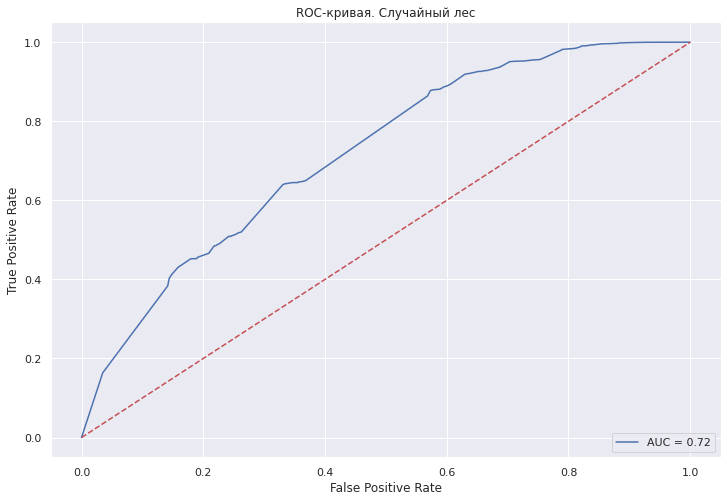

In [110]:
probs = rf_over.predict_proba(X_test_lbl)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)

plt.title("ROC-кривая. Случайный лес")
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:0.2f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

Метрика `AUC-ROC` на тестовой выборке чуть снизилась, но не сильно: до 0,72.

In [111]:
%%time
predict = dt_over.predict(X_test_lbl)
print(f"Precision: {precision_score(y_test, predict)}")
print(f"Recall: {recall_score(y_test, predict)}")
print(f"F1: {f1_score(y_test, predict)}")
probs = dt_over.predict_proba(X_test_lbl)
probs = probs[:, 1]
roc_auc = roc_auc_score(y_test, probs)
print(f"AUC-ROC: {roc_auc}")

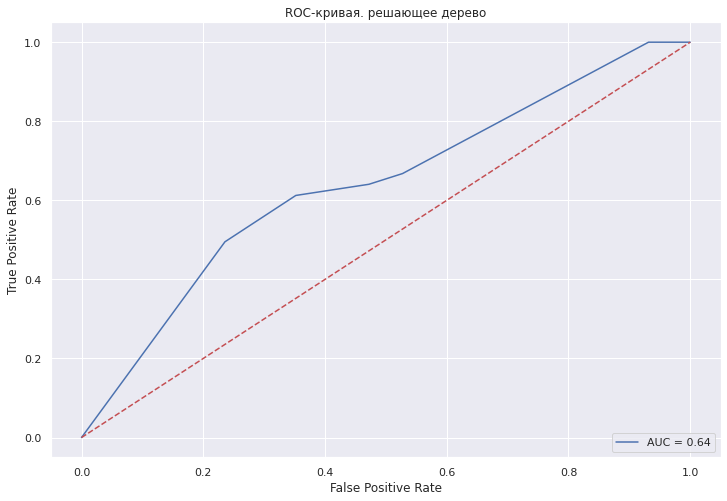

In [112]:
probs = dt_over.predict_proba(X_test_lbl)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)

plt.title("ROC-кривая. решающее дерево")
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:0.2f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

Решающее дерево на тестовой выборке показали заметное падение метрик `AUC-ROC` и отставание от случайного леса, хотя показатели ощутимо выше случайной модели.

Посмотрим как логистическая регрессия покажет себя на тестовой выборке.

In [113]:
%%time
predict = lr_cv.best_estimator_.predict(X_test_w)
print(f"Precision: {precision_score(y_test, predict)}")
print(f"Recall: {recall_score(y_test, predict)}")
print(f"F1: {f1_score(y_test, predict)}")
probs = lr_cv.predict_proba(X_test_w)
probs = probs[:, 1]
roc_auc = roc_auc_score(y_test, probs)
print(f"AUC-ROC: {roc_auc}")

Переобучение логистической регрессии не свойственно и она хорошо показала себя на тестовой выборке: падение метрики `AUC-ROC` произошло, но не так драматично, как у дерева и леса.

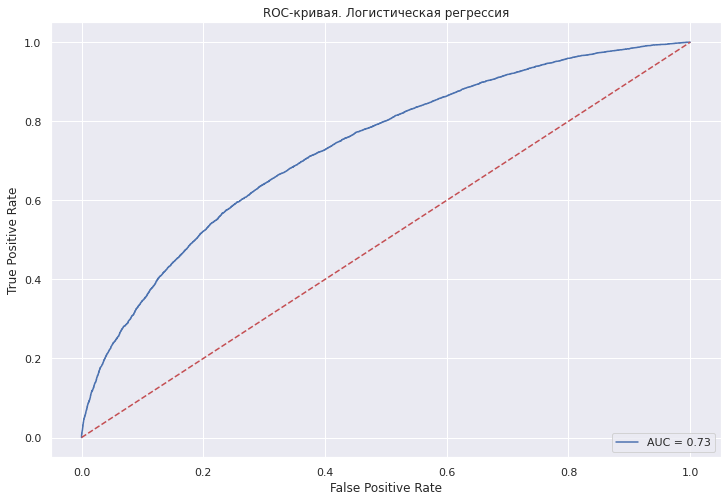

In [114]:
probs = lr_cv.best_estimator_.predict_proba(X_test_w)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)

plt.title("ROC-кривая. Логистическая регрессия")
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:0.2f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

Удивительно, но логистическая кривая на тестовой выборке обогнала всех, пусть и с минимальным отрывом: `AUC-ROC` 0,73.

Посмотрим, какие из признаков оказались наиболее значимыми при прогнозе:

In [115]:
feature_importance = pd.DataFrame(
    {
        "feature": list(X_test_w.columns),
        "feature_importance": [abs(i) for i in lr_cv.best_estimator_.coef_[0]],
    }
)
feature_importance.sort_values("feature_importance", ascending=False).head(20)

Одним из направлений дальнейшего улучшения модели логистической регрессии может стать отбрасывание наименее значимых признаков:

In [116]:
%%time
predict = lr_cv.best_estimator_.predict(X_test_w)
# roc_auc = roc_auc_score(y_test, predict) ### должны быть вероятности
probs = lr_cv.predict_proba(X_test_w)
probs = probs[:, 1]

X_train_new = X_train_w.copy()
X_test_new = X_test_w.copy()
aucs = [{"params": X_test_new.shape[1], "auc": roc_auc, "X_test": X_test_new}]
best_auc = 0

features_rank = feature_importance.sort_values("feature_importance", ascending=True)[
    "feature"
]
lr_new = LogisticRegression(random_state=42, max_iter=75)

for f in features_rank[:-2]:
    X_train_new.drop([f], axis=1, inplace=True)
    X_test_new.drop([f], axis=1, inplace=True)
    roc_auc = cross_val_score(lr_new, X_train_new, y_train, scoring="roc_auc").mean()
    aucs.append({"params": X_test_new.shape[1], "auc": roc_auc, "X_test": X_test_new})
    if best_auc < roc_auc:
        best_auc = roc_auc

print(f"best AUC-ROC: {best_auc}")

In [117]:
aucs = pd.DataFrame(aucs)

In [118]:
aucs.head()

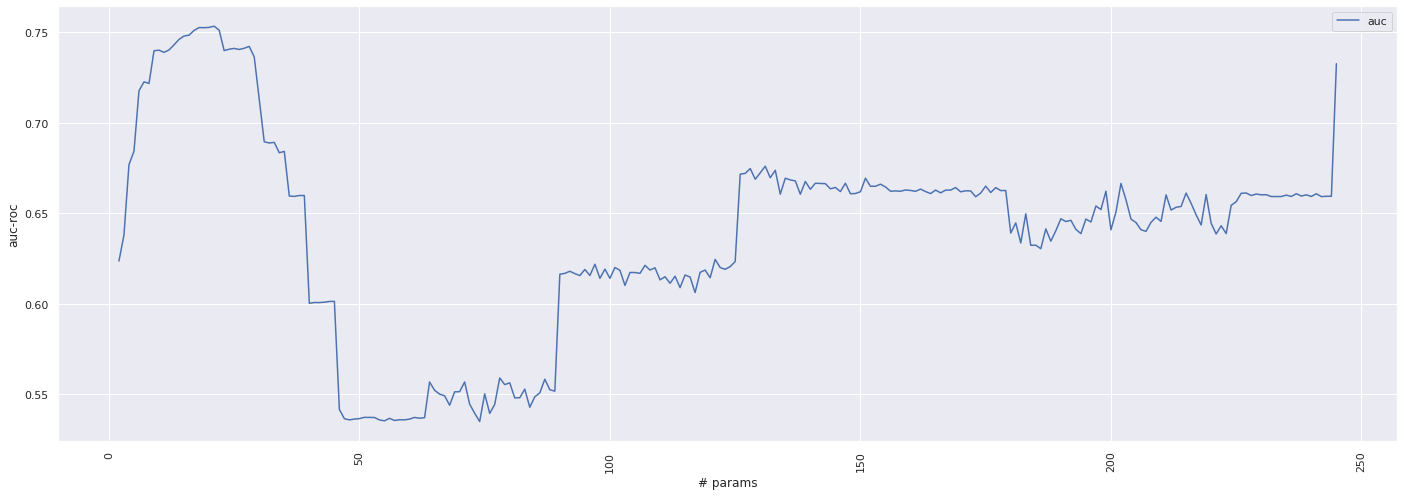

In [119]:
aucs.plot(
    kind="line",
    x="params",
    y="auc",
    rot=90,
    figsize=(24, 8),
    xlabel="# params",
    ylabel="auc-roc",
);

Интересно, что пик находится вблизи довольно малого числа параметров от 15 до 22. 

In [120]:
aucs.sort_values(by='auc', ascending=False).head(10)

На кросс-валидации было достигнуто наилучшее значение `AUC-ROC` 0.75. Посмотрим, что удастся получить на тестовой выборке

In [121]:
lr_best = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=100),
    param_grid={
        "C": [0.001, 0.01, 1, 10, 100],
    },
    cv=5,
    scoring="roc_auc",
)
lr_best.fit(X_train_w[list(features_rank.iloc[::-1].loc[:16])], y_train)

In [122]:
%%time
probs = lr_best.predict_proba(X_test_w[list(features_rank.iloc[::-1].loc[:16])])
probs = probs[:, 1]
roc_auc = roc_auc_score(y_test, probs)
print(f"AUC-ROC: {roc_auc}")

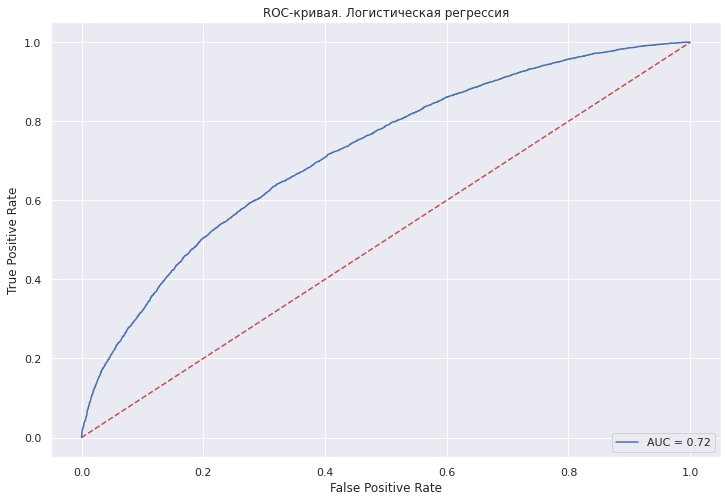

In [123]:
probs = lr_best.best_estimator_.predict_proba(X_test_w[list(features_rank.iloc[::-1].loc[:16])])
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)

plt.title("ROC-кривая. Логистическая регрессия")
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:0.2f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

При избавлении от наименее значимых параметров, когда количество признаков остаётся в диапазоне 15-22 можно выйти на более высокое плато значений (на тренировочной выборке), и там значение `AUC-ROC` на тестовой выборке оказывается на уровне 0,72. Так что наивысшее значение по-прежнему остаётся на полном множестве признаков и  `AUC-ROC` равно 0,73.

### Выводы

После обучения на тренировочной выборке и проверки на тестовой, и наилучшее значение метрики `ROC-AUC` демонстрирует логистическая регрессия.

## Оценка годовой прибыли предсказательной модели

Оценим, какой дополнительный доход принесёт наша модель за год, чтобы понять, окупит ли она затраты на внедрение.

Наша тренировочная выборка охватывает период в год, тогда как тестовая выборка покрывает лишь первые 35 недель 2017 года. Вычислим доход в виде депозита, удержанного с ненадёжных постояльцев на имеющемся интервале и экстраполируем результат на полный год.

In [124]:
predict_canceled = pd.Series(
    lr_cv.best_estimator_.predict(X_test_w), name="predict_canceled"
)

Совместим предсказания, фактические отказы и необходимы для расчётов признаки постояльцев:

In [125]:
predict_profit_loss = pd.concat(
    [
        X_test[["arrival_date_month", "reserved_room_type"]],
        y_test,
        predict_canceled,
    ],
    axis=1,
)

Добавим информацию о востребованном депозите на основе прогноза отмены брони. Попутно в датафрейм будут добавлены данные о ценах и сезонных факторах.

In [126]:
predict_profit_loss = add_deposit(predict_profit_loss)

Осталось посчитать доход за период, когда мы правильно предсказали отмену брони и затребовали депозит:

In [127]:
incoming_additional = model_income(predict_profit_loss)
incoming_additional

Внедрение предсказательной системы обещает прирост прибыли в размере более 1 млн. уже на первых (хотя и наиболее "горячих") 8 месяцах года.

В ситуации же, когда мы не смогли предсказать отмену, отель несёт те же расходы, что и без внедрения предсказательной системы.

### Выводы

В ходе подготовки данных к машинному обучению были исследованы признаки, которые помогли бы выявить ненадёжных постояльцев: это как правило путешественники без маленьких детей и автомобиля, а также, возможно, из ряда "ненадёжных" стран.

По результатам обучения моделей на тренировочной выборке и проверки на кросс-валидации, наилучшее значение метрики `AUC-ROC` показала оттюнингованная логистическая регрессия. 

Вычисление ожидаемой дополнительной прибыли составило на тестовой выборке более 1 млн. на 8 месяцах, что позволяет прогнозировать окупаимость внедрения прогностической системы в течение первого года эксплуатации.